In [186]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

### Load data and remove columns not necessary 

In [149]:
df = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [155]:
test_passenger_ids = testdf["PassengerId"]

In [156]:
df = df.drop(columns=["PassengerId","Name", "Ticket","Cabin"] )
testdf = testdf.drop(columns=["PassengerId","Name", "Ticket","Cabin"])

### Check for missing values in both set of data

In [161]:
df.isnull().sum()[df.isnull().sum() > 0]

Age         177
Embarked      2
dtype: int64

In [162]:
testdf.isnull().sum()[testdf.isnull().sum() > 0]

Age     86
Fare     1
dtype: int64

### Fill missing data and encoded categorical variable

In [163]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

testdf['Age'] = testdf.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

In [164]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [165]:
testdf['Fare'].fillna(df['Fare'].median(), inplace=True)

In [171]:
df['AgeQuartile'] , q = pd.qcut(df['Age'], 4, labels=[1, 2, 3, 4], retbins=True)
testdf['AgeQuartile'] = pd.cut(testdf['Age'], bins=q, labels=[1, 2, 3, 4], include_lowest=True)

In [166]:
df['FamilySize'] = df['SibSp'] + df['Parch']+1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

testdf['FamilySize'] = testdf['SibSp'] + testdf['Parch']+1
testdf['IsAlone'] = (testdf['FamilySize'] == 1).astype(int)


In [168]:
df['FarePerPerson'] = df['Fare'] / df['FamilySize'].replace(0, 1)
testdf['FarePerPerson'] = testdf['Fare'] / testdf['FamilySize'].replace(0, 1)

In [169]:
df['FarePerPersonBin'], bins = pd.qcut(df['FarePerPerson'], 4, labels=[1, 2, 3, 4], retbins=True)

In [170]:
testdf['FarePerPersonBin'] = pd.cut(testdf['FarePerPerson'], bins=bins, labels=[1, 2, 3, 4], include_lowest=True)

In [173]:
df = pd.get_dummies(df, columns = ["Pclass","Sex","AgeQuartile","Embarked","FarePerPersonBin"])
test_x = pd.get_dummies(testdf, columns = ["Pclass","Sex","AgeQuartile","Embarked","FarePerPersonBin"])


In [184]:
df.head(5)

,Survived,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FarePerPerson,Pclass_1,Pclass_2,...,AgeQuartile_2,AgeQuartile_3,AgeQuartile_4,Embarked_C,Embarked_Q,Embarked_S,FarePerPersonBin_1,FarePerPersonBin_2,FarePerPersonBin_3,FarePerPersonBin_4
0,0,22.0,1,0,7.2500,2,0,3.62500,0,0,...,1,0,0,0,0,1,1,0,0,0
1,1,38.0,1,0,71.2833,2,0,35.64165,1,0,...,0,0,1,1,0,0,0,0,0,1
2,1,26.0,0,0,7.9250,1,1,7.92500,0,0,...,1,0,0,0,0,1,0,1,0,0
3,1,35.0,1,0,53.1000,2,0,26.55000,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,1,1,8.05000,0,0,...,0,1,0,0,0,1,0,1,0,0


### Train and test data

In [176]:
X = df.drop(columns = ["FamilySize","Survived","SibSp","Parch","Age","Fare","FarePerPerson"],axis = 1).copy()
test_x = test_x.drop(columns = ["FamilySize","SibSp","Parch", "Age","Fare","FarePerPerson"],axis = 1)

In [177]:
Y = df["Survived"].copy()

In [190]:
model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X, Y, cv=10, scoring='accuracy')

In [191]:
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Mean Accuracy: 0.8114
Standard Deviation: 0.0261


In [180]:
model.fit(X, Y)

RandomForestClassifier(random_state=42)

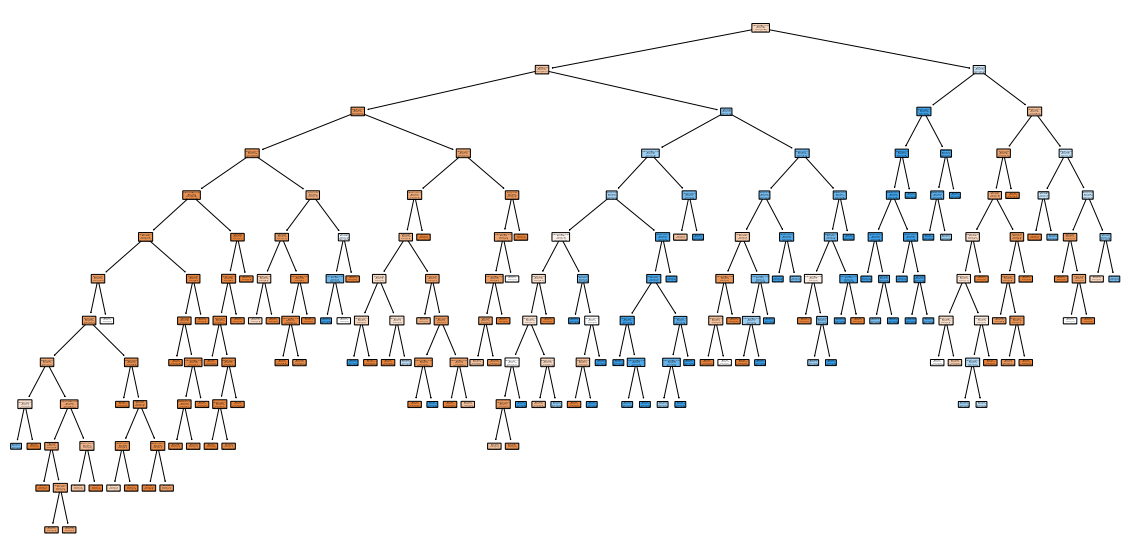

In [187]:
plt.figure(figsize=(20,10))
plot_tree(model.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Not Survived', 'Survived'], 
          filled=True, 
          rounded=True)
plt.show()


In [181]:
predictions = model.predict(test_x)

In [182]:
submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,  # from test.csv
    "Survived": predictions
})

In [183]:
submission["Survived"].value_counts()

0    280
1    138
Name: Survived, dtype: int64

In [135]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [192]:
submission.to_csv("submission.csv", index=False)